<a href="https://colab.research.google.com/github/Tyrannozavr/machine_learning/blob/master/%D0%BE%D1%81%D1%82%D0%B0%D0%BB%D0%B0%D1%81%D1%8C_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
!git clone https://github.com/CipiOrhei/TMBuD

fatal: destination path 'TMBuD' already exists and is not an empty directory.


In [2]:
from skimage.transform import resize
import pandas
import os
import torch
import cv2
# from google.colab.patches import cv2_imshow
from skimage.io import imread
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
root = 'TMBuD/'
images_dir = root + 'images/'
lesions_dir = root + 'gt_label/'
dataset_csv = root + 'DATASET SPLIT.csv'

Ну я сразу скажу, что здесь вроде как предусмотрен какой то файл для более простой загрузки датасета, наверное, я сильно не разбирался, установил зависимости, он выдал мне какую то непонятную ошибку и я решил, что мне проще просто использовать эти картинки и не мучить голову свою

In [4]:
table = pandas.read_csv(dataset_csv)

In [5]:
table.head()

,Picture Name,Building Name,Coordinates Landmark,Coordinates image,GT salient edges,GT labels,Condition,Quality,Dataset STANDARD,Dataset 3_2,Dataset 3_5_NIGHT,Dataset 3_N,SEMSEG_EVAL_FULL,END
0,1,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.75174775294593; 21.22478407583839,Done,Done,NIGHT,GOOD,TRAIN,None,TEST,TEST,TRAIN,'
1,2,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.751577081296176; 21.22472497882864,Done,Done,DAY,GOOD,TRAIN,TRAIN,TRAIN,TRAIN,TRAIN,'
2,3,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.75127239101317; 21.22480049167443,Done,Done,DAY,GOOD,TRAIN,TRAIN,TRAIN,TRAIN,TEST,'
3,4,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.75127239101317; 21.22480049167443,Done,Done,DAY,GOOD,VAL,TEST,TEST,TEST,TRAIN,'
4,5,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.751259791003264; 21.224710204576198,Done,Done,DAY,GOOD,TEST,None,None,None,TRAIN,'


Так, ну для начала я понял, что смысла в этой таблице для меня особо нет т.к. здесь куча данных, но то, что мне нужно (например количество окон) отсутствует, как и адрес изображения, не знаю какой смысл мне в этой цифре, мол, вот 1 изображение. Была бы польза от полного имени

In [6]:
def get_name(numb):
    if len(str(numb)) == 1:
        return f'0000{numb}.png'
    if len(str(numb)) == 2:
        return f'000{numb}.png'
    if len(str(numb)) == 3:
        return f'00{numb}.png'
    if len(str(numb)) == 4:
        return f'0{numb}.png'
    if len(str(numb)) == 5:
        return f'{numb}.png'

In [7]:
images = []
lesions = []
size = (256, 256)

for i in range(1, 11000):
  img_or = cv2.imread(images_dir+get_name(i), cv2.IMREAD_UNCHANGED)
  img_les = cv2.imread(lesions_dir+get_name(i), cv2.IMREAD_UNCHANGED)
  if img_or is not None and img_les is not None:
    images.append(img_or)
    lesions.append(img_les)

Дело в том, что для решения задачи сегментации мне понадобится метка здания, а для решения задачи регрессии, я думаю, мне понадобятся отмеченные окна, вот их метки я и буду подавать на регрессионную модель, возможно лучше даже обучить 2 разные модели, пока думаю над этим

In [8]:
background =    (0,     0,      0)
sky =           (255,   0,      0)
vegetation =    (0,     255,    0)
building =      (125,   125,    0)
window =        (0,     255,    255)
ground =        (125,   125,    125)
noise =         (0,     0,      255)
door =          (0,     125,    125)

background = np.array((0, 0, 0), dtype=np.uint8)

Нужно оптимизировать этот алгоритм, бо это ужас, к сожалению не удалось сделать красиво одним срезом, похоже так только каждый элемент можно перебрать, ну или я не полностью знаю возможности numpy

Я все таки решил, что надеждней обучить 2 модели, одна будет рисовать фасад здания, другая делать сегментацию окон, дальше эти окна (ну, маску) либо на регрессию, либо даже что то попроще, просто сосчитат пространства зарисованные

Сейчас я попробую при помощи этой функции создать датасет для сегментации окон

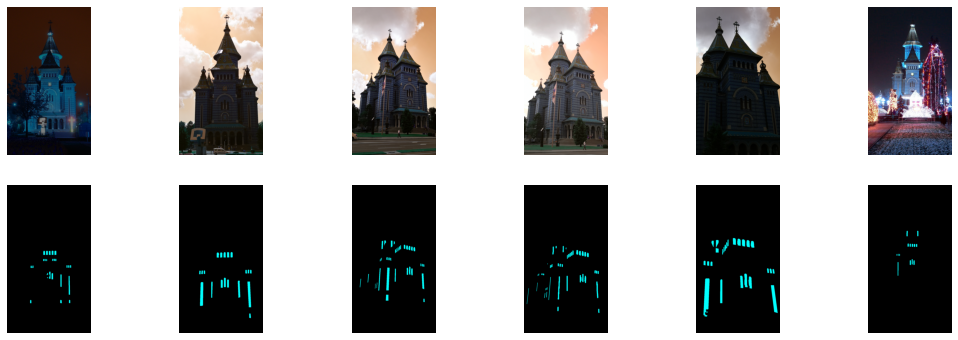

In [11]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
df_windows = []
for image in lesions:
  image = image.copy()
  for idx_row, row in enumerate(image):
    for idx_col, cell in enumerate(row):
      if any(cell != [0, 255, 255]):
            image[idx_row, idx_col] = [0, 0, 0]
  df_windows.append(image)





plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(images[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(df_windows[i])
plt.show();

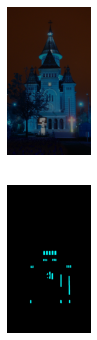

In [15]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(1):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(images[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(df_windows[i])
plt.show();

Следующий цикл проходит по сегментированным изображениям и всего лишь удаляет все, кроме окон

In [16]:
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) for y in df_windows]

In [18]:
!sudo mkdir TMBuD/wind_segm

In [19]:
segm = 'TMBuD/wind_segm'
os.chdir(segm)
for idx, image in enumerate(df_windows):
  cv2.imwrite(f'{idx}.png', image)

In [20]:
len(df_windows)

298

In [21]:
! pip install segmentation-models-pytorch

In [23]:
import segmentation_models_pytorch as smp

In [ ]:
model = smp.Unet(
    encoder_name="resnet34",   
    encoder_weights="imagenet",
    in_channels=1,             
    classes=3,                 
)

In [35]:
len(X)

298

In [36]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [200, 275])

In [42]:
X, Y = np.array(X), np.array(Y)

In [43]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [44]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [41]:
type(X)

list

In [ ]:


BACKBONE = 'resnet34'

IMAGE_HEIGHT_ORIG = 1024
IMAGE_WIDTH_ORIG = 1024
IMAGE_CHANNELS_ORIG = 3

IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
IMAGE_CHANNELS = 3

BATCH_SIZE = 8

SAMPLE_SIZE = 15

NUM_EPOCHS = 30

THRESHOLD = 0.7

LRATE = 0.0001

# Check the number of available cpu cores.
# This variable is used to set the num workers in the data loader.
NUM_CORES = os.cpu_count()

NUM_CORES
import segmentation_models_pytorch as smp
# 3x512x512 RGB pre-processed image


# seg_model Output:
# .................

# Mask with values in range 0 to 1


ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' 

# create segmentation model with pretrained encoder
seg_model = smp.Unet(
    encoder_name=BACKBONE, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(BACKBONE, ENCODER_WEIGHTS)

print(seg_model)